In [2]:
import os
import copy
import time
import pickle
import numpy as np
from torch.utils import data
from tqdm import tqdm
import torch
from options import args_parser
from update import LocalUpdate, test_inference
from models.imagenet import resnext50
from utils import get_dataset, average_weights, exp_details
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
start_time = time.time()
data_dir='/home/hh239/ece685/data/imagenette2'
dataset='imagenet'
local_ep = 3
local_bs = 16
num_users = 5
epochs = 70
frac = 1
iid = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load dataset and user groups
train_dataset, test_dataset, user_groups = get_dataset(
    data_dir=data_dir, 
    dataset=dataset, 
    num_users=num_users, 
    iid=iid
)

# BUILD MODEL
global_model = resnext50(
    baseWidth=4,
    cardinality=32)

# Set the model to train and send it to device.
if torch.cuda.is_available():
    global_model = torch.nn.DataParallel(global_model).cuda()
else:
    global_model.to(device)

file_name = '/home/hh239/ece685/ece685_project/results'+\
    f'/imagenet_resnext_{epochs}_C[{frac}]_iid[{iid}]_E[{local_ep}]_B[{local_bs}].pkl'

with open(file_name, 'rb') as f:
    logger = pickle.load(f)

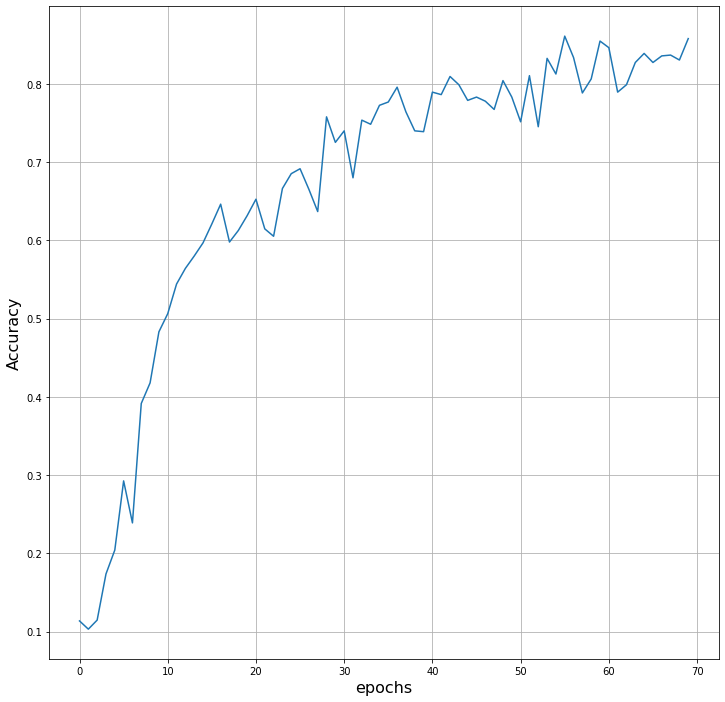

In [10]:
acc = logger['acc']
x = np.arange(epochs)

fig, ax = plt.subplots(figsize=(12, 12))
plt.plot(x, acc)
plt.xlabel('epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.grid()
plt.savefig('results/fedaverage_acc.png', dpi=300)
plt.show()

In [21]:
len(trainset)



9469

In [3]:
start_time = time.time()
data_dir='../data/imagenette2'
dataset='imagenet'
local_ep = 5
local_bs = 16
num_users = 1
epochs = 210
frac = 0.2
iid = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load dataset and user groups
train_dataset, test_dataset, _ = get_dataset(
    data_dir=data_dir,
    dataset=dataset,
    num_users=num_users,
    iid=iid
)

# BUILD MODEL
base_model = resnext50(
    baseWidth=4,
    cardinality=32)

# Set the model to train and send it to device.
if torch.cuda.is_available():
    base_model = torch.nn.DataParallel(base_model).cuda()
else:
    base_model.to(device)

file_name = './results'+\
    f'/imagenet_resnext_{epochs}_S[{frac}]_iid[{iid}]_E[{local_ep}]_B[{local_bs}].pkl'

with open(file_name, 'rb') as f:
    logger = pickle.load(f)

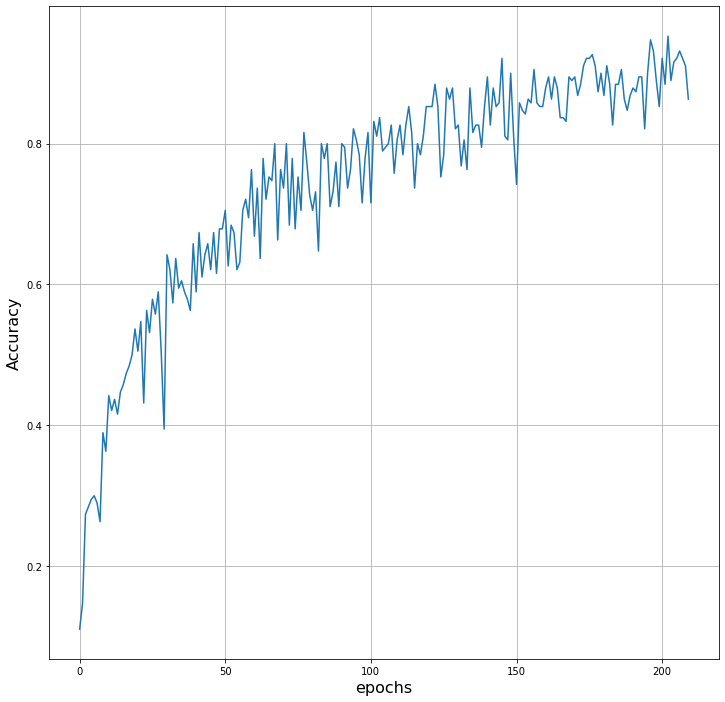

In [4]:
acc = logger['acc']
x = np.arange(epochs)

fig, ax = plt.subplots(figsize=(12, 12))
plt.plot(x, acc)
plt.xlabel('epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.grid()
plt.savefig('results/base_average_acc.png', dpi=300)
plt.show()
